In [1]:
!git clone https://github.com/mapooon/Face2Diffusion

fatal: destination path 'Face2Diffusion' already exists and is not an empty directory.


In [2]:
cd Face2Diffusion

/content/Face2Diffusion


In [3]:
!gdown https://drive.google.com/uc?id=1Lf_mwMgme_HVYJCkViGr4TfGOfKw9PhE -O checkpoints/mapping.pt
!gdown https://drive.google.com/uc?id=1DjUf-ib612SDDt86TRlsDkHqXTeYx030 -O checkpoints/msid.pt

Downloading...
From (original): https://drive.google.com/uc?id=1Lf_mwMgme_HVYJCkViGr4TfGOfKw9PhE
From (redirected): https://drive.google.com/uc?id=1Lf_mwMgme_HVYJCkViGr4TfGOfKw9PhE&confirm=t&uuid=a0f9d6db-9cf5-42ab-a238-306ad8f6cec5
To: /content/Face2Diffusion/checkpoints/mapping.pt
100% 48.0M/48.0M [00:00<00:00, 63.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1DjUf-ib612SDDt86TRlsDkHqXTeYx030
From (redirected): https://drive.google.com/uc?id=1DjUf-ib612SDDt86TRlsDkHqXTeYx030&confirm=t&uuid=c314c016-7d11-497a-9939-78b226439515
To: /content/Face2Diffusion/checkpoints/msid.pt
100% 85.9M/85.9M [00:00<00:00, 236MB/s]


In [4]:
!pip uninstall -y diffusers transformers huggingface_hub accelerate jax jaxlib flax face_alignment timm
!pip install torch torchvision tokenizers==0.13.3 huggingface_hub==0.15.1 accelerate==0.18.0 diffusers==0.14.0 --no-deps transformers==4.30.2 face_alignment timm
import sys
sys.path.append('.')

Found existing installation: diffusers 0.14.0
Uninstalling diffusers-0.14.0:
  Successfully uninstalled diffusers-0.14.0
Found existing installation: transformers 4.30.2
Uninstalling transformers-4.30.2:
  Successfully uninstalled transformers-4.30.2
Found existing installation: huggingface-hub 0.15.1
Uninstalling huggingface-hub-0.15.1:
  Successfully uninstalled huggingface-hub-0.15.1
Found existing installation: accelerate 0.18.0
Uninstalling accelerate-0.18.0:
  Successfully uninstalled accelerate-0.18.0
Found existing installation: face-alignment 1.4.1
Uninstalling face-alignment-1.4.1:
  Successfully uninstalled face-alignment-1.4.1
Found existing installation: timm 1.0.15
Uninstalling timm-1.0.15:
  Successfully uninstalled timm-1.0.15
  Using cached huggingface_hub-0.15.1-py3-none-any.whl.metadata (8.0 kB)
  Using cached accelerate-0.18.0-py3-none-any.whl.metadata (16 kB)
  Using cached diffusers-0.14.0-py3-none-any.whl.metadata (32 kB)
  Using cached transformers-4.30.2-py3-no

## Import modules

In [5]:
import os
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import torch
import numpy as np
import cv2
from torch import nn
import argparse
import torchvision
import face_alignment
from PIL import Image
from torch.nn import functional as F
from src import modules
from src import utils
from src.msid import msid_base_patch8_112
from transformers.models.clip.modeling_clip import CLIPTextTransformer,CLIPTextModel
from src import mod

/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## Prepare Face2Diffusion Pipeline

In [6]:
assert torch.cuda.is_available() # you must use GPU e.g. T4
device = 'cuda'


pretrained_model_name_or_path="CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path, torch_dtype=torch.float16,safety_checker=None).to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

pipe.text_encoder.text_model.forward = mod.forward_texttransformer.__get__(pipe.text_encoder.text_model, CLIPTextTransformer)
pipe.text_encoder.forward = mod.forward_textmodel.__get__(pipe.text_encoder, CLIPTextModel)

img2text = modules.IMG2TEXTwithEXP(384*4,384*4,768)
img2text.load_state_dict(torch.load('checkpoints/mapping.pt',map_location='cpu'))
img2text=img2text.to(device)
img2text.eval()

msid = msid_base_patch8_112(ext_depthes=[2,5,8,11])
msid.load_state_dict(torch.load('checkpoints/msid.pt'))
msid=msid.to(device)
msid.eval()

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


MSIDEncoder(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        

# !!!Set input image and prompt!!!

In [7]:
input_prompt = 'f l eating bread in front of the Eiffel Tower' # You must input "f l" to represent the subject S*
guidance_scale = 10.0 # classifier-free guidance
n_samples = 8 # num of images to generate
img_path = 'input/0.jpg' # path to input image

## Tokenize input text

In [8]:
identifier='f'
ids = pipe.tokenizer(
                input_prompt,
                padding="do_not_pad",
                truncation=True,
                max_length=pipe.tokenizer.model_max_length,
            ).input_ids
placeholder_token_id=pipe.tokenizer(
                identifier,
                padding="do_not_pad",
                truncation=True,
                max_length=pipe.tokenizer.model_max_length,
            ).input_ids[1]
assert placeholder_token_id in ids,'identifier does not exist in prompt'
pos_id = ids.index(placeholder_token_id)

input_ids = pipe.tokenizer.pad(
        {"input_ids": [ids]},
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        return_tensors="pt",
    ).input_ids

## encode input face and text

In [9]:
#identity encoding
detector=face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D,flip_input=False,device='cuda' if torch.cuda.is_available() else 'cpu')
lmk=np.array(detector.get_landmarks(img_path))[0]
img = np.array(Image.open(img_path).convert('RGB'))
with torch.no_grad():
    M=utils.align(lmk)
    img=utils.warp_img(img,M,(112,112))/255
    img=torch.tensor(img).permute(2,0,1).unsqueeze(0)
    img=(img-0.5)/0.5
    idvec = msid.extract_mlfeat(img.to(device).float(),[2,5,8,11])
    tokenized_identity_first, tokenized_identity_last = img2text(idvec,exp=None)
    hidden_states = utils.get_clip_hidden_states(input_ids.to(device),pipe.text_encoder).to(dtype=torch.float32)
    hidden_states[[0], [pos_id]]=tokenized_identity_first.to(dtype=torch.float32)
    hidden_states[[0], [pos_id+1]]=tokenized_identity_last.to(dtype=torch.float32)
    pos_eot = input_ids.to(dtype=torch.int, device=hidden_states.device).argmax(dim=-1)

#text encoding
with torch.autocast("cuda"):
    with torch.no_grad():
        encoder_hidden_states = pipe.text_encoder(hidden_states=hidden_states, pos_eot=pos_eot)[0]

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth
100%|██████████| 85.7M/85.7M [00:03<00:00, 24.5MB/s]
Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip
100%|██████████| 91.9M/91.9M [00:06<00:00, 15.8MB/s]


## Generate images

  0%|          | 0/1 [00:00<?, ?it/s]

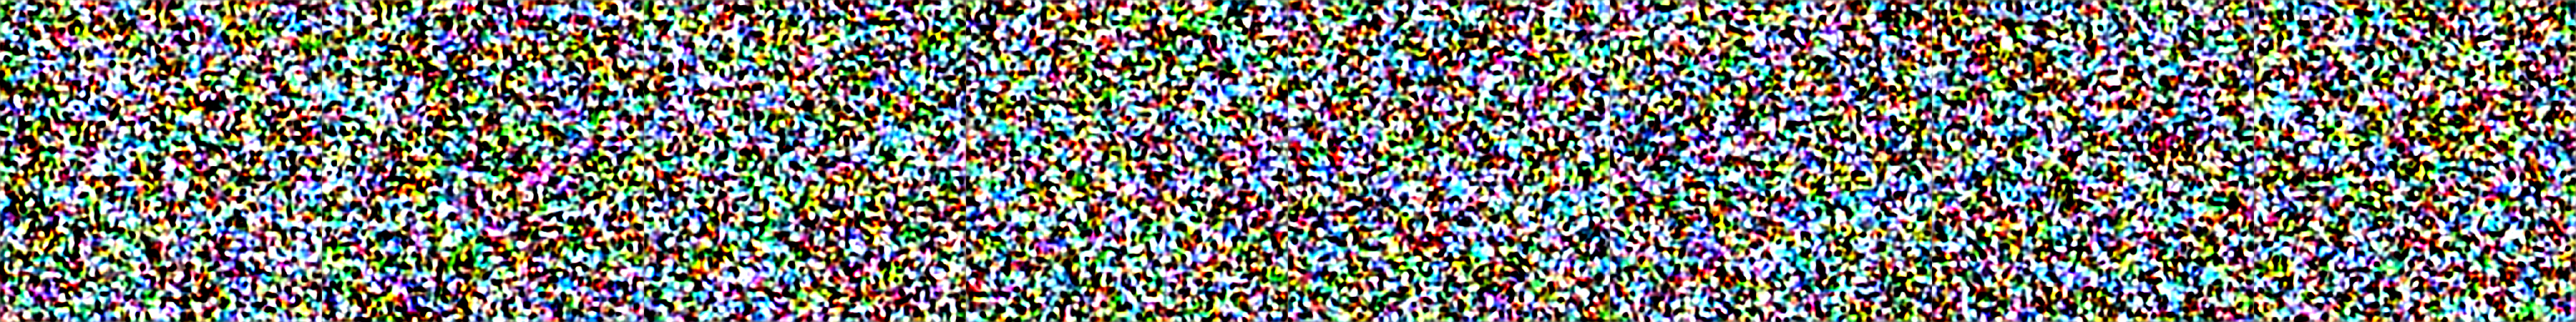

In [11]:
#diffusion process
generator = torch.Generator(device).manual_seed(0)
image = pipe(prompt_embeds=encoder_hidden_states, num_inference_steps=30, guidance_scale=guidance_scale,generator=generator,num_images_per_prompt=n_samples).images#[0]
image = np.concatenate([np.array(image[i]) for i in range(len(image))],1)
image = Image.fromarray(image.astype(np.uint8))

image